In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    percentile: int = 20,
    min_com_size: int = 3,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            msg1 = 'pearson\n(th = {:.2f})\n'
            msg1 = msg1.format(np.min(pearson[percentile][pearson[percentile] > 0]))
            msg2 = 'spearman\n(th = {:.2f})\n'
            msg2 = msg2.format(np.min(spearman[percentile][spearman[percentile] > 0]))
            axes[0, ii].set_ylabel(msg1, fontsize=12)
            axes[1, ii].set_ylabel(msg2, fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    figsize=None,
    colorbar=False,):
    
    percentiles = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(percentiles)) if figsize is None else figsize
    fig, axes = plt.subplots(len(percentiles), 2, figsize=figsize)

    for ii, perc in enumerate(sorted(percentiles, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 0].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=12, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 1].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=12, y=1.03)
        axes[ii, 1].set_ylabel('Using {:d} {:s} \n'.format(perc, '%'), fontsize=12)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(
    organized_data: dict,
    include: Union[range, List[int]] = None,
    config: Config = None,):
    
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = list(regions.keys())[:19] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy()
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy().astype(float)
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas': atlas,
        'atlas_limited': x,
        'contour': contour,
    }
    return output

## Load

In [122]:
config = Config()

subject = 6
session = 1
num_kmeans_regions = 256

lowcut = 0.002
highcut = 0.9
order = 2

df = pd.DataFrame()
df_bp = pd.DataFrame()
for run in [1, 3, 5, 7]:
    load = load_organized_data(
        folder='atlas-{:d}_unfiltered_unnormalized'.format(num_kmeans_regions),
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    ca = {k: v for k, v in load['ca'].items()}
    ca_bp = {
        k: apply_bandpass(
            x=v,
            fs=config.ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order, )
        for k, v in load['ca'].items()
    }
    
    # normalize
    mean = np.mean([item.mean() for item in ca.values()])
    sd = np.mean([item.std() for item in ca.values()])
    ca_n = {k: (v - mean) / sd for k, v in ca.items()}
    
    mean = np.mean([item.mean() for item in ca_bp.values()])
    sd = np.mean([item.std() for item in ca_bp.values()])
    ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}

    df = pd.concat([df, pd.DataFrame.from_dict(ca_n)])
    df_bp = pd.concat([df_bp, pd.DataFrame.from_dict(ca_bp_n)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

atls_org = organize_atlas(load)

## Hierarchical clustering

In [123]:
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy as sp_hier

In [124]:
x_dict = {k: np.array(list(v.values())).reshape(1, -1) for k, v in df.to_dict().items()}

In [125]:
x = np.concatenate(list(x_dict.values()))
y = pdist(X=x, metric='correlation')
z = sp_hier.linkage(y, method='ward', metric='euclidean', optimal_ordering=False)

x.shape, y.shape, z.shape

((256, 5500), (32640,), (255, 4))

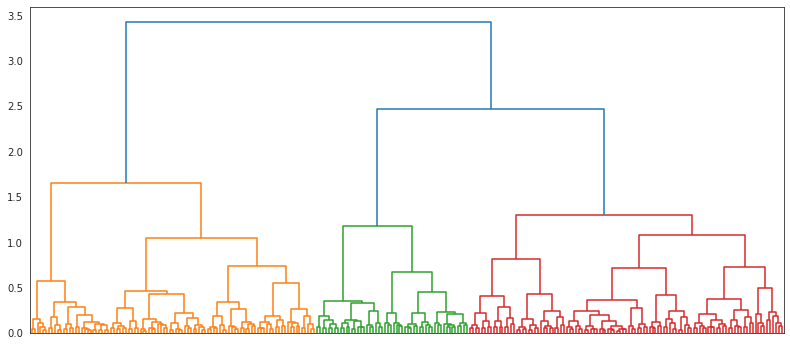

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(13.5, 6))

dn = sp_hier.dendrogram(
    Z=z,
    p=30,
    truncate_mode=None,
    color_threshold=None,
    get_leaves=True,
    orientation='top',
    labels=list(x_dict.keys()),
    count_sort=False,
    distance_sort=False,
    show_leaf_counts=True,
    no_plot=False,
    no_labels=True,
    leaf_font_size=None,
    leaf_rotation=-90,
    leaf_label_func=None,
    show_contracted=False,
    link_color_func=None,
    ax=ax,
    above_threshold_color='C0',
)

In [177]:
partition = {node: color for node, color in zip(dn['leaves'], dn['leaves_color_list'])}
color2idx = {c: i for i, c in enumerate(set(partition.values()))}

partition = {node: color2idx[c] for node, c in partition.items()}
partition = dict(sorted(partition.items()))

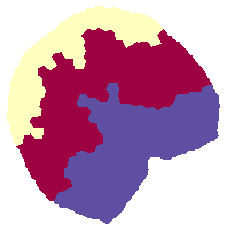

In [178]:
cortex = np.ones(load['atlas_kmeans'].shape) * -1
for node, comm_idx in partition.items():
    region_id = node_labels[node]
    cortex[load['atlas_kmeans'] == region_id] = comm_idx
    
data2plt = np.ma.masked_where(~load['mask'], cortex)
plt.imshow(data2plt, cmap='Spectral', interpolation='none')
plt.axis('off')
plt.show()

In [181]:
def plot_tree(dn, pos=None, figsize=(12, 5)):
    icoord = np.array(dn['icoord'])
    dcoord = np.array(dn['dcoord'])
    color_list = np.array(dn['color_list'])
    xmin, xmax = icoord.min(), icoord.max()
    ymin, ymax = dcoord.min(), dcoord.max()

    if pos:
        icoord = icoord[pos]
        dcoord = dcoord[pos]
        color_list = color_list[pos]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for xs, ys, color in zip(icoord, dcoord, color_list):
        ax.plot(xs, ys, color)
    ax.set_xlim(xmin - 0.02 * xmax, xmax + 0.02 * xmax)
    ax.set_ylim(ymin, ymax + 0.05*abs(ymax))
    plt.show()
    
    return fig, ax

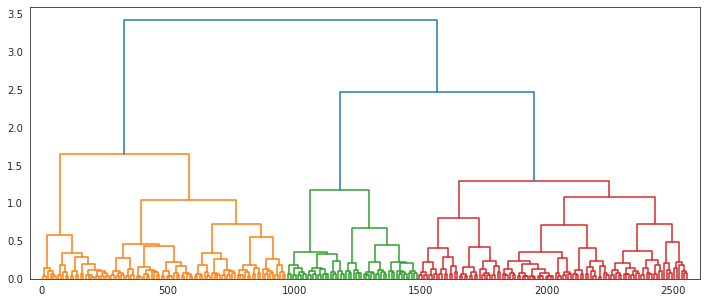

In [183]:
fig, ax = plot_tree(dn)